### Pennylane implementation of the QEMC algorithm (Ref. https://arxiv.org/abs/2308.10383)
Correct version!

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# Matplolib style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

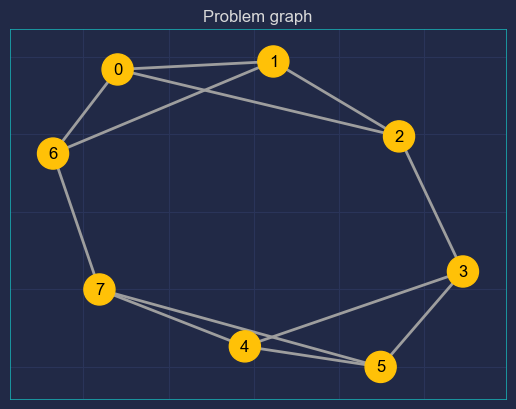

In [169]:
# set the random seed
np.random.seed(42)

# number of qubits in the circuit
n_nodes = 8
# graph edges as a list of tuples
graph = [(0, 1), (0, 2), (0, 6), (1, 2), (1, 6), \
         (3, 2), (3, 4), (3, 5), (4, 5), (4, 7), \
         (5, 7), (6, 7)]
graph_nx = nx.Graph(graph)

# set node colors and size
node_colors = ["#FFC107" for node in graph_nx.nodes()]
node_size = 500

# set edge colors and width
edge_colors = ["#9E9E9E" for edge in graph_nx.edges()]
edge_width = 2

# set layout
pos = nx.spring_layout(graph_nx)

# draw graph
nx.draw_networkx(graph_nx, pos=pos, with_labels=True, node_color=node_colors, node_size=node_size, edge_color=edge_colors, width=edge_width)
plt.title("Problem graph")
plt.show()

In [170]:
def bitstring_to_float(bit_string_sample):
    float_val = 0.
    for n, val in enumerate(bit_string_sample[::-1]):
        float_val += val * 2.**(n)
    return float_val

# Random initialization of parameters
n_layers = 2
params = 0.01 * np.random.rand(n_layers, 3, 3, requires_grad=True)

# QEMC layer definition
def qemc_layer(params, **kwargs):
    global c;
    n_wires = kwargs.pop('n_wires') # default value not specified: raises KeyError if n_wires is not specified
    rs = kwargs.pop('rs') # range: hyperparameter
    for i in range(n_wires):
        qml.RX(params[i][0], wires = i)
        qml.RY(params[i][1], wires = i)
        qml.RZ(params[i][2], wires = i)
    for j in range(n_wires):
        qml.CNOT(wires = [j, (j+rs[c]) % n_wires])
    c += 1

n_wires = 3; rs = [1, 2]; N = 8 # shots = 3*N**2: same as in q-QEMC (I'm doing cs-QEMC, now) 
dev = qml.device("default.qubit", wires = n_wires, shots = None) # shots = None: analytic probability distribution

c = 0;
@qml.qnode(dev)
def circuit(params):
    global c; c = 0
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    qml.layer(qemc_layer, len(rs), params, rs = rs, n_wires = n_wires)
    return qml.probs()

print(f'Quantum circuit drawing:\n{qml.draw(circuit)(params)}')

Quantum circuit drawing:
0: ──H──RX(0.00)──RY(0.01)──RZ(0.00)─╭●────╭X──RX(0.01)──RY(0.00)──RZ(0.01)─╭●─╭X────┤  Probs
1: ──H──RX(0.00)──RY(0.01)──RZ(0.00)─╰X─╭●─│───RX(0.01)──RY(0.00)──RZ(0.01)─│──╰●─╭X─┤  Probs
2: ──H──RX(0.00)──RY(0.00)──RZ(0.00)────╰X─╰●──RX(0.00)──RY(0.00)──RZ(0.01)─╰X────╰●─┤  Probs


In [171]:
def qemc_maxcut(N, n_layers, edges):
    B = N/2; # definition of B
    # quick note: N is the number of nodes in the graph
    print("QEMC level: p={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(n_layers, 3, 3, requires_grad=True)

    def objective(params):
        probs = circuit(params); cost  = 0
        for edge in edges:
            # j and k are the nodes connected by the edge
            # 0: j, 1: k
            d_jk = np.abs(probs[edge[0]] - probs[edge[1]]); s_jk = probs[edge[0]] + probs[edge[1]]
            edge_cost = (d_jk - 1/B)**2 + (s_jk - 1/B)**2
            cost += edge_cost
        return cost
    
    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdamOptimizer(stepsize = 0.99, beta1 = 0.9, beta2 = 0.99, eps = 1e-08)

    # optimize parameters in objective
    params = init_params
    iterations = 300
    for i in range(iterations):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, objective(params)))

    # sample measured bitstrings 3*N**2 times. No need to to this, since I'm doing this analytically:
    # just take the exact distribution
    probabilities = circuit(params)

    # print optimal parameters and most frequently sampled bitstring
    most_freq_bit_string = np.argmax(probabilities)
    print("Optimized (params) vectors:\n{}".format(params))
    print("Most frequently sampled bit string is: {:03b}".format(most_freq_bit_string))
    print(f"Circuit drawing, n_layers={n_layers}:")
    print( qml.draw(circuit)(params) )

    return objective(params), probabilities

objective, probabilities = qemc_maxcut(n_nodes, n_layers, graph)

QEMC level: p=2
Objective after step     5:  0.5516845
Objective after step    10:  0.4478743
Objective after step    15:  0.2916554
Objective after step    20:  0.3977245
Objective after step    25:  0.3057023
Objective after step    30:  0.2594629
Objective after step    35:  0.2413441
Objective after step    40:  0.2193567
Objective after step    45:  0.2026553
Objective after step    50:  0.1835921
Objective after step    55:  0.1808137
Objective after step    60:  0.1771518
Objective after step    65:  0.1753163
Objective after step    70:  0.1743052
Objective after step    75:  0.1741877
Objective after step    80:  0.1727382
Objective after step    85:  0.1715908
Objective after step    90:  0.1709000
Objective after step    95:  0.1703845
Objective after step   100:  0.1697338
Objective after step   105:  0.1691664
Objective after step   110:  0.1705596
Objective after step   115:  0.1788234
Objective after step   120:  0.1866498
Objective after step   125:  0.1753785
Objective

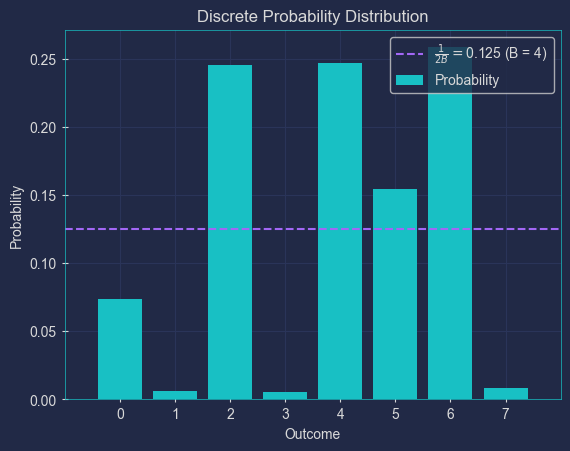

In [172]:
def plot_probability_distribution(probabilities):
    # Get the number of possible outcomes
    num_outcomes = len(probabilities)

    # Generate x-axis values for the outcomes
    x = range(num_outcomes)

    # plot the probability thresholds
    B = N/2; threshold = 1 / (2*B)
    plt.hlines(threshold, -1, num_outcomes, colors='C2', linestyles='dashed', label=r'$\frac{1}{2B} =$' + \
               f'{threshold:.3f} (B = {int(B)})')
    plt.xlim(-1, num_outcomes); plt.xticks(x)
    
    # Plot the probability distribution
    plt.bar(x, probabilities, label='Probability')
    plt.xlabel('Outcome')
    plt.ylabel('Probability')
    plt.title(f'Discrete Probability Distribution')
    plt.legend(loc = 'best', frameon = True, fancybox=True)
    plt.show()
plot_probability_distribution(probabilities)

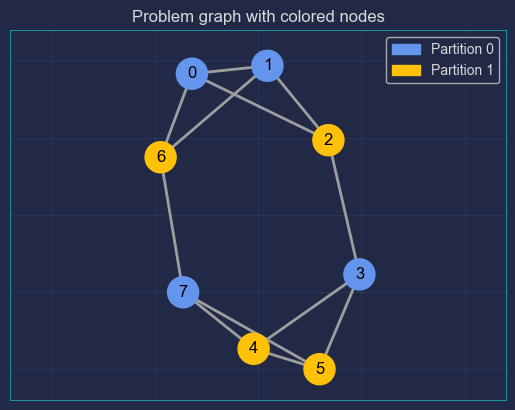

Cut value = 10; Optimal cut = 10.


In [173]:
# function to compute the 'cut' value
def compute_cut(partition, graph):
    cut_value = 0
    for edge in graph:
        node1, node2 = edge
        if partition[node1] != partition[node2]:
            cut_value += 1
    return cut_value

# obtain the partition
B = N/2; threshold = 1 / (2*B)
partition = [0 if prob < threshold else 1 for prob in probabilities]

# set node colors based on partition
node_colors = ["#6495ED" if val == 0 else "#FFC107" for val in partition]
# change the order of node_colors to match graph_nx.nodes
sorted_node_colors = [node_colors[node] for node in graph_nx.nodes()]

# positions
def get_index(dict, i):
    return list(dict.keys())[i]

# pos = nx.spring_layout(graph_nx); 
sorted_pos = sorted(pos.items(), key=lambda x: x[0]); sorted_pos = dict(sorted_pos)

# draw graph with updated node colors
nx.draw_networkx(graph_nx, pos=pos, with_labels=True, node_color=sorted_node_colors, node_size=node_size, edge_color=edge_colors, width=edge_width)

plt.title("Problem graph with colored nodes")

# create legend
partition0_patch = Patch(color='#6495ED', label='Partition 0')
partition1_patch = Patch(color='#FFC107', label='Partition 1')
plt.legend(handles=[partition0_patch, partition1_patch], loc='best', frameon=True, fancybox=True)
plt.xlim(-1.2, 1.2); plt.ylim(-1.2, 1.2)
plt.show()

# compute the 'cut' value
Cut = compute_cut(partition, graph)
print(f"Cut value = {Cut}; Optimal cut = 10.")

Now, I think everything is working as intended! We're just missing running this 10 times and computing the graphs: Average best-so-far vs. iteration number, etc.

Simple example, used in the PIC2 report:

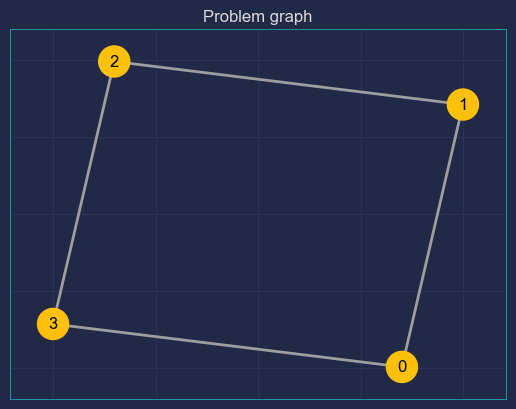

In [33]:
# set the random seed
np.random.seed(42)

# number of qubits in the circuit
n_nodes = 4
# graph edges as a list of tuples
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
graph_nx = nx.Graph(graph)

# set node colors and size
node_colors = ["#FFC107" for node in graph_nx.nodes()]
node_size = 500

# set edge colors and width
edge_colors = ["#9E9E9E" for edge in graph_nx.edges()]
edge_width = 2

# set layout
pos = nx.spring_layout(graph_nx)

# draw graph
nx.draw_networkx(graph_nx, pos=pos, with_labels=True, node_color=node_colors, node_size=node_size, edge_color=edge_colors, width=edge_width)
plt.title("Problem graph")
plt.show()

In [39]:
def bitstring_to_float(bit_string_sample):
    float_val = 0.
    for n, val in enumerate(bit_string_sample[::-1]):
        float_val += val * 2.**(n)
    return float_val

# Random initialization of parameters
n_layers = 2
params = 0.01 * np.random.rand(n_layers, 2, 3, requires_grad=True)

# QEMC layer definition
def qemc_layer(params, **kwargs):
    global c;
    n_wires = kwargs.pop('n_wires') # default value not specified: raises KeyError if n_wires is not specified
    rs = kwargs.pop('rs') # range: hyperparameter
    for i in range(n_wires):
        qml.RX(params[i][0], wires = i)
        qml.RY(params[i][1], wires = i)
        qml.RZ(params[i][2], wires = i)
    # for j in range(n_wires):
    #     qml.CNOT(wires = [j, (j+rs[c]) % n_wires]) # For more than 2 qubits, use this.
    # For 2 qubits, this is required instead.
    qml.CNOT(wires = [0, 1])
    c += 1

n_wires = 2; rs = [1, 2]; N = 4 # shots = 3*N**2: same as in q-QEMC (I'm doing cs-QEMC, now) 
dev = qml.device("default.qubit", wires = n_wires, shots = None) # shots = None: analytic probability distribution

c = 0;
@qml.qnode(dev)
def circuit(params):
    global c; c = 0
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    qml.layer(qemc_layer, len(rs), params, rs = rs, n_wires = n_wires)
    return qml.probs()

print(f'Quantum circuit drawing:\n{qml.draw(circuit)(params)}')

Quantum circuit drawing:
0: ──H──RX(0.01)──RY(0.01)──RZ(0.01)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)─╭●─┤  Probs
1: ──H──RX(0.00)──RY(0.00)──RZ(0.01)─╰X──RX(0.00)──RY(0.01)──RZ(0.00)─╰X─┤  Probs


In [46]:
def qemc_maxcut(N, n_layers, edges):
    B = N/2; # definition of B
    # quick note: N is the number of nodes in the graph
    print("QEMC level: p={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(n_layers, 2, 3, requires_grad=True)

    def objective(params):
        probs = circuit(params); cost  = 0
        for edge in edges:
            # j and k are the nodes connected by the edge
            # 0: j, 1: k
            d_jk = np.abs(probs[edge[0]] - probs[edge[1]]); s_jk = probs[edge[0]] + probs[edge[1]]
            edge_cost = (d_jk - 1/B)**2 + (s_jk - 1/B)**2
            cost += edge_cost
        return cost
    
    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdamOptimizer(stepsize = 0.99, beta1 = 0.9, beta2 = 0.99, eps = 1e-08)

    # optimize parameters in objective
    params = init_params
    iterations = 50 # Was 300 before.
    for i in range(iterations):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, objective(params)))

    # sample measured bitstrings 3*N**2 times. No need to to this, since I'm doing this analytically:
    # just take the exact distribution
    probabilities = circuit(params)

    # print optimal parameters and most frequently sampled bitstring
    most_freq_bit_string = np.argmax(probabilities)
    print("Optimized (params) vectors:\n{}".format(params))
    print("Most frequently sampled bit string is: {:03b}".format(most_freq_bit_string))
    print(f"Circuit drawing, n_layers={n_layers}:")
    print( qml.draw(circuit)(params) )

    return objective(params), probabilities

objective, probabilities = qemc_maxcut(n_nodes, n_layers, graph)

QEMC level: p=2
Objective after step     5:  0.0532138
Objective after step    10:  0.0240543
Objective after step    15:  0.2182810
Objective after step    20:  0.1391712
Objective after step    25:  0.0064004
Objective after step    30:  0.0268581
Objective after step    35:  0.0060081
Objective after step    40:  0.0001855
Objective after step    45:  0.0024525
Objective after step    50:  0.0011514
Optimized (params) vectors:
[[[ 0.00772246 -3.20134532  0.24984166]
  [ 0.00815463  1.31554048  1.22590228]]

 [[ 0.61258195 -2.76111787  0.00358465]
  [ 0.40980856  0.29518256  0.00623298]]]
Most frequently sampled bit string is: 000
Circuit drawing, n_layers=2:
0: ──H──RX(0.01)──RY(-3.20)──RZ(0.25)─╭●──RX(0.61)──RY(-2.76)──RZ(0.00)─╭●─┤  Probs
1: ──H──RX(0.01)──RY(1.32)───RZ(1.23)─╰X──RX(0.41)──RY(0.30)───RZ(0.01)─╰X─┤  Probs


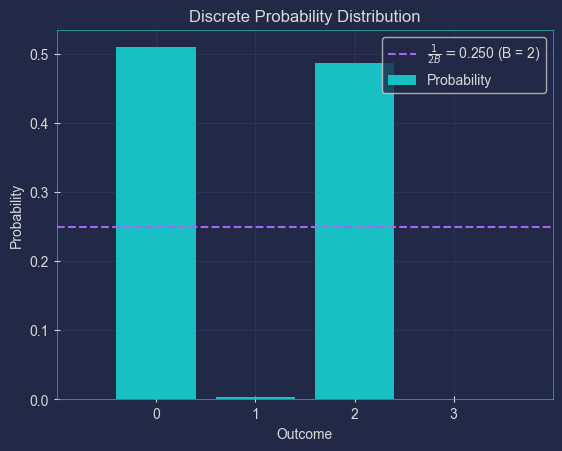

In [47]:
def plot_probability_distribution(probabilities):
    # Get the number of possible outcomes
    num_outcomes = len(probabilities)

    # Generate x-axis values for the outcomes
    x = range(num_outcomes)

    # plot the probability thresholds
    B = N/2; threshold = 1 / (2*B)
    plt.hlines(threshold, -1, num_outcomes, colors='C2', linestyles='dashed', label=r'$\frac{1}{2B} =$' + \
               f'{threshold:.3f} (B = {int(B)})')
    plt.xlim(-1, num_outcomes); plt.xticks(x)
    
    # Plot the probability distribution
    plt.bar(x, probabilities, label='Probability')
    plt.xlabel('Outcome')
    plt.ylabel('Probability')
    plt.title(f'Discrete Probability Distribution')
    plt.legend(loc = 'best', frameon = True, fancybox=True)
    plt.show()
plot_probability_distribution(probabilities)

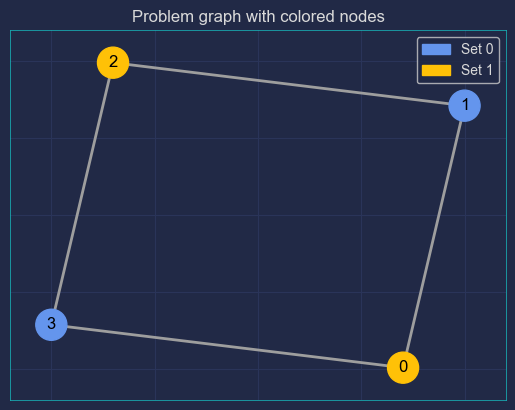

Cut value = 4; Optimal cut = 10.


In [49]:
# function to compute the 'cut' value
def compute_cut(partition, graph):
    cut_value = 0
    for edge in graph:
        node1, node2 = edge
        if partition[node1] != partition[node2]:
            cut_value += 1
    return cut_value

# obtain the partition
B = N/2; threshold = 1 / (2*B)
partition = [0 if prob < threshold else 1 for prob in probabilities]

# set node colors based on partition
node_colors = ["#6495ED" if val == 0 else "#FFC107" for val in partition]
# change the order of node_colors to match graph_nx.nodes
sorted_node_colors = [node_colors[node] for node in graph_nx.nodes()]

# positions
def get_index(dict, i):
    return list(dict.keys())[i]

# pos = nx.spring_layout(graph_nx); 
sorted_pos = sorted(pos.items(), key=lambda x: x[0]); sorted_pos = dict(sorted_pos)

# draw graph with updated node colors
nx.draw_networkx(graph_nx, pos=pos, with_labels=True, node_color=sorted_node_colors, node_size=node_size, edge_color=edge_colors, width=edge_width)

plt.title("Problem graph with colored nodes")

# create legend
partition0_patch = Patch(color='#6495ED', label='Set 0')
partition1_patch = Patch(color='#FFC107', label='Set 1')
plt.legend(handles=[partition0_patch, partition1_patch], loc='best', frameon=True, fancybox=True)
plt.xlim(-1.2, 1.2); plt.ylim(-1.2, 1.2)
plt.show()

# compute the 'cut' value
Cut = compute_cut(partition, graph)
print(f"Cut value = {Cut}; Optimal cut = 10.")